# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
#from IPython.display import display, HTML
#% matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

#IPython.OutputArea.auto_scroll_threshold = 9999;

In [2]:
def loadclean_transcript():
    ''' get the transcript dataframe and clean it. It contains all the information about "interactions"
        of the customers with the starbucks app, like receiving and watching offers, buying at shops or
        receiving money (e.g. as a discount) upon completion of an offer (e.g. 'discount', 'bogo').
        
        the original "value" column contains different versions of 'offer(_)id' that is cleaned
        and combined to a new column "offer_id". 
        "value" also contains informations about transactions like money spent and money obtained
        (e.g. for the completion of an offer). These information will be separated into new columns
        "money_gained" (by customers) and "money_spent" by customers.
        the original "value" column will then be dropped.
        
        the event column contains information about the type of event that occurs between the customers
        and starbucks (or the app). The different categorial values will be used as dummy columns to better 
        describe the type of interaction. 
        
        Returns:
        
        df      cleaned pd.Dataframe of the transcript.json file.
        '''
    transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
    
    transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
    transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))
    transcript['offer_id'] = transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    
    transcript['money_gained'] = transcript['value'].apply(lambda x: x.get('reward'))
    transcript['money_spent'] = transcript['value'].apply(lambda x: x.get('amount'))
    
    dummies = pd.get_dummies(transcript['event'])
    transcript = pd.concat([transcript, dummies], axis=1)
    
    transcript.drop(['offer id' , 'value', 'event'] , axis=1, inplace=True)
    
    return(transcript)

In [28]:
def plot_completion_rate(df, bin_col, bin_col_length, offer_type, plot_col, completion_thresh):
    
    ''' This function produces a facetgrid bar plot that represents the interaction of different
        "social groups" (age groups per gender) with different offers. 
    
    Input:
    
        df                   dataframe object
        bin_col              column of df to bin (e.g. age column)
        bin_col_length       length of the binning intervall (e.g. 10 or 15 years)
        offer_type           type of offer to visualize (e.g. "discount" or "bogo")
        plot_col             column to use as y-axis for the plots (e.g. "viewed/received", "completed/received", "completed/viewed")
        completion_thresh    threshold to restrict the visualized bars. 
                             if plot_col == 'viewed/received', only values < completion_thresh will be plotted
                             if plot_col == 'completed/received', only values < completion_thresh will be plotted
                             if plot_col == 'completed/viewd', only values > completion_thresh will be plotted
    Returns:
        
    '''
    
    bins = np.arange(df[bin_col].min(), df[bin_col].max(), bin_col_length)

    groups = df.groupby(['offer_id', 'offer_type',pd.cut(t_p_p_merg.age, bins, precision=0), 'gender',])
    
    output = groups.sum().dropna().drop(['time', 'transaction', 'reward',
                                         'difficulty', 'duration', 'email',
                                         'mobile', 'social', 'web', 'age',
                                         'became_member_on', 'money_spent'], axis = 1)
    
    output['completed/received'] = output['offer completed'] / output['offer received']
    output['completed/viewed'] = output['offer completed'] / output['offer viewed']
    output['viewed/received'] = output['offer viewed'] / output['offer received']
    output = output.reset_index()
    output = output[output['offer_type'] == offer_type]
    
    bin_col_left_list = output[bin_col].drop_duplicates().apply(lambda x: x.left).astype(int).to_list()
    bin_col_right_list = output[bin_col].drop_duplicates().apply(lambda x: x.right).astype(int).to_list()
    
    bin_col_list = sorted(list(set(bin_col_left_list + bin_col_right_list)))
    
    col_list = []
    
    for x in range(0, len(bin_col_list)+1):
        if x == len(bin_col_list) -1:
            break
        else:
            col_list.append((f'{bin_col}: {bin_col_list[x]} - {bin_col_list[x + 1]}'))
    
    row_list = [offer_type + ' ' + str(x) for x in range(1,output['offer_id'].nunique() + 1)]
    
    pd.set_option('display.max_rows', output.shape[0]+1)
    display(output.head())
    
    if plot_col == 'viewed/received':
        output = output[output[plot_col] < completion_thresh]
    
    if plot_col == 'completed/received':
        output = output[output[plot_col] < completion_thresh]
        
    if plot_col == 'completed/viewed':
        output = output[output[plot_col] > completion_thresh]
    
    g = sns.FacetGrid(output, col="age", row = 'offer_id', palette='viridis', hue="gender")
    g.map(sns.barplot, "gender", plot_col, order=["M", "F", "O"])

    #col_list = ["age: 18-33", "age: 33-48", "age: 48-63", "age: 63-78", "age: 78-93"]
    #discount_list = ["Discount 1", "Discount 2", "Discount 3", "Discount 4"]

    for col in range(0, g.axes.shape[1]):
        for row in range(0, g.axes.shape[0]):
            if col == 0:
                g.axes[row,col].set_ylabel(row_list[row], size = 20, labelpad = 20)
            if row == 0:
                g.axes[row,col].set_title(col_list[col], size =20)
            else:
                g.axes[row,col].set_title("", size =20)
                
    plt.suptitle('Ratio of completed offers (' + str(plot_col) + ') per age group and gender', fontsize=30, y=1.08)
    
    return()

# Goal and important questions

It is the goal of this project to analyse behaviours of different customer groups and draw business-relevant conclusions about the effectiveness and potential improvements for the different offer types. 

1) What is the distribution of customer income per age/gender?

2) What is the total number of completed offers of a single person per age/gender?

3) How do different age/gender groups interact with different offers?

4) Who received and completed which offer? - A detailed view

### Load and prepare different databases

### Portfolio data
Giving information about the different offer types, e.g. reward, difficulty, duration etc.

In [4]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

### create dummy columns for the list of channels
df_dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)

portfolio = pd.concat([portfolio, df_dummies], axis = 1).drop('channels', axis = 1)

display(portfolio.head(10))

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### Transcript data
Giving information about the interaction of a customer with the Starbucks app, e.g. receiving and completing offers or making transactions. This is actually a pretty "messy" dataset, so it was cleaned using the loadclean_transcript function. 

In [5]:
transcript = loadclean_transcript()

display(transcript.head(5))

,person,time,offer_id,money_gained,money_spent,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,0,1,0,0


### Profile database
Giving information about the customers, e.g. age, income, gender.

In [6]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

### all people that have income == 'NaN' also do not have a gender and the "unreasonable" age of 118.
### therefore these rows will be dropped.
profile = profile.dropna()

display(profile.head())

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


## Merge databases

In [7]:
transcript_portfolio_merged = transcript.merge(portfolio, right_on = 'id', left_on = 'offer_id', how = 'outer').drop('id', axis = 1)

In [8]:
t_p_p_merg = transcript_portfolio_merged.merge(profile, right_on = 'id', left_on = 'person', how = 'outer').drop('id', axis = 1)
display(t_p_p_merg.head())

,person,time,offer_id,money_gained,money_spent,offer completed,offer received,offer viewed,transaction,reward,...,duration,offer_type,email,mobile,social,web,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,1,0,0,5.0,...,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,20170509.0,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,0,0,1,0,5.0,...,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,20170509.0,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,NaN,1,0,0,0,5.0,...,7.0,bogo,1.0,1.0,0.0,1.0,F,75.0,20170509.0,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,0,1,0,0,5.0,...,5.0,bogo,1.0,1.0,1.0,1.0,F,75.0,20170509.0,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,5.0,NaN,1,0,0,0,5.0,...,5.0,bogo,1.0,1.0,1.0,1.0,F,75.0,20170509.0,100000.0


In [9]:
transcript_per_person = transcript.groupby('person').sum().drop('time', axis =1).reset_index()
transcript_per_person['money_gained/money_spent in %'] = (transcript_per_person['money_gained']/transcript_per_person['money_spent']*100).round(1)

### for the division by zero case, the np.inf values will be replaced by 10. The max int value (without 10) was 5, so it will be clearly distinguishable if a person did not look at a single offer but completed offers.
transcript_per_person['offer completed/offer viewed'] = (pd.to_numeric(transcript_per_person['offer completed'])/pd.to_numeric(transcript_per_person['offer viewed'])).round(2).replace([np.inf, -np.inf], 10)

profile_trans_merged = profile.merge(transcript_per_person, right_on = 'person', left_on = 'id', how = 'right').drop('person', axis = 1)



### How does a person interact with a single offer? 

In [10]:
t_p_p_merg_grouped = t_p_p_merg.groupby(['person', 'offer_id']).sum().reset_index().drop(['time', 'money_spent', 'transaction', 'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web', 'age', 'became_member_on', 'income'], axis = 1)
display(t_p_p_merg_grouped.head(10))

print('This is the number of offers that has been received by all customers: ')
print(str(t_p_p_merg_grouped['offer received'].sum()) + '\n')

print('This is the number of offers that has been viewed by all customers: ')
print(str(t_p_p_merg_grouped['offer viewed'].sum()) + '\n')

print('View ratio: ')
print(str(round(t_p_p_merg_grouped['offer viewed'].sum()/t_p_p_merg_grouped['offer received'].sum(), 2) *100) + ' %' + '\n')

print('This is the number of "bogo" and "discount" offers that has been received by all customers: ')
print(str(t_p_p_merg_grouped[(t_p_p_merg_grouped['offer_id'] != '3f207df678b143eea3cee63160fa8bed') & (t_p_p_merg_grouped['offer_id'] != '5a8bc65990b245e5a138643cd4eb9837')]['offer received'].sum()) + '\n')

print('This is the number of "bogo" and "discount" offers that has been viewed by all customers: ')
print(str(t_p_p_merg_grouped[(t_p_p_merg_grouped['offer_id'] != '3f207df678b143eea3cee63160fa8bed') & (t_p_p_merg_grouped['offer_id'] != '5a8bc65990b245e5a138643cd4eb9837')]['offer viewed'].sum()) + '\n')

print('This is the number of "bogo" and "discount" offers that has been completed by all customers: ')
print(str(t_p_p_merg_grouped[(t_p_p_merg_grouped['offer_id'] != '3f207df678b143eea3cee63160fa8bed') & (t_p_p_merg_grouped['offer_id'] != '5a8bc65990b245e5a138643cd4eb9837')]['offer completed'].sum()) + '\n')

print('This is the number of "bogo" and "discount" offers that have been viewed and completed: ')
print(str(t_p_p_merg_grouped[(t_p_p_merg_grouped['offer_id'] != '3f207df678b143eea3cee63160fa8bed') & (t_p_p_merg_grouped['offer_id'] != '5a8bc65990b245e5a138643cd4eb9837') & (t_p_p_merg_grouped['offer completed'] == 1) & (t_p_p_merg_grouped['offer viewed'] == 1)].shape[0]) + '\n')

print('Completion ratio (received bogo + discount offers / viewed and completed offers): ')
print(str(round(t_p_p_merg_grouped[(t_p_p_merg_grouped['offer_id'] != '3f207df678b143eea3cee63160fa8bed') & (t_p_p_merg_grouped['offer_id'] != '5a8bc65990b245e5a138643cd4eb9837') & (t_p_p_merg_grouped['offer completed'] == 1) & (t_p_p_merg_grouped['offer viewed'] == 1)].shape[0] / t_p_p_merg_grouped[(t_p_p_merg_grouped['offer_id'] != '3f207df678b143eea3cee63160fa8bed') & (t_p_p_merg_grouped['offer_id'] != '5a8bc65990b245e5a138643cd4eb9837')]['offer received'].sum(), 2) * 100) + ' %')


,person,offer_id,money_gained,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,1,1
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0,2,2
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,1,1,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,1,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0.0,0,1,1
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0.0,0,1,1


This is the number of offers that has been received by all customers: 
76277

This is the number of offers that has been viewed by all customers: 
57725

View ratio: 
76.0 %

This is the number of "bogo" and "discount" offers that has been received by all customers: 
61042

This is the number of "bogo" and "discount" offers that has been viewed by all customers: 
46894

This is the number of "bogo" and "discount" offers that has been completed by all customers: 
33579

This is the number of "bogo" and "discount" offers that have been viewed and completed: 
19254

Completion ratio (received bogo + discount offers / viewed and completed offers): 
32.0 %


### Comments:

About 76000 offers have been sent to the customers whereas about 58000 have been actively viewed. This is a "view ratio" of 76 %. The number of received and viewed offers also includes informational offers, that cannot be completed by definition.

About 61000 bogo and discount offers have been sent to customers, whereas about 47000 of them have been viewed. In total 33500 bogo and discount offers have been completed but only about 19000 offers have been completed after they have been viewed. 
Looking at the effectivity of the discount program itself, this is a really important figure. Starbucks aims to engage more customers to buy one of their products by sending them offers. If a customer does not view the offer but still completes it (and gets the reward) it can be estimated, that the customer would have bought the products without receiving the offer at all. On the other hand, if a customer views an offer and is "attracted" by its reward, then the advertising effect of the offer made the customer buy the product.
So in total from the 61000 bogo and discount offers that have been sent, only 32 % have been viewed and completed (on purpose) by the customer. This is definitely a number that has to be increased in order to make the effectivenes of the Starbucks reward app. 

## Visualize data

## 1) Distribution of customer income per age/gender

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


This is the distribution of gender in the profile data:


M    8484
F    6129
O     212
Name: gender, dtype: int64

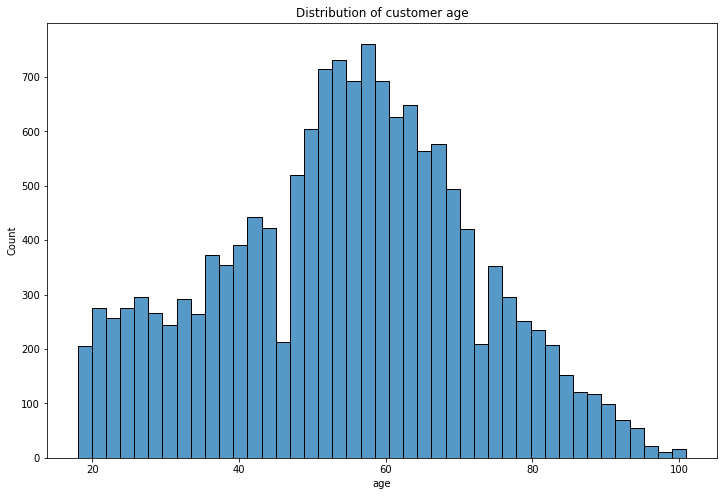

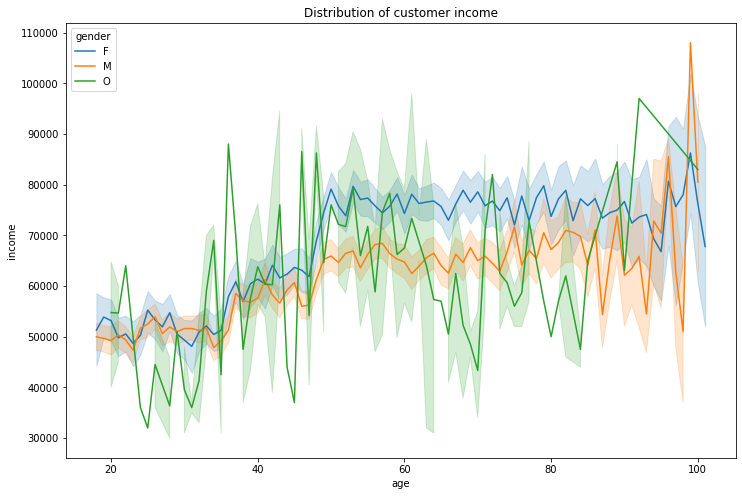

In [11]:
display(profile.head())
print('This is the distribution of gender in the profile data:')
display(profile.gender.value_counts())

sns.histplot(profile.age)
plt.title('Distribution of customer age')
plt.show()

sns.lineplot(y = 'income', x = 'age', hue = 'gender', data = profile)
plt.title('Distribution of customer income')
plt.show()


## Comments: 
There are about 15000 customers in the dataset. About 8500 are male, 6100 female and 200 others. 
The histogram shows the distribution of customer age in the dataset. The ages range from 18 to roughly 100 years whereas most of the customers roughly fall in the age range between 55 and 65. 
The line plot at the bottoms shows the distribution of customer income per gender at the different ages. For male and female it can be seen that they have roughly the same income at younger years. With increasing age, there seems to be an income gap whereas female would earn more. In general younger customers earn less money and there are two bigger steps of the income at about 38 years and 50 years. 

## Visualize summarized person information
This gives an overview over all transactions of each person and the number of received, viewed and completed offers. 

In [12]:
display(profile_trans_merged.dropna().head())

,gender,age,id,became_member_on,income,money_gained,money_spent,offer completed,offer received,offer viewed,transaction,money_gained/money_spent in %,offer completed/offer viewed
0,M,33.0,0009655768c64bdeb2e877511632db8f,20170421.0,72000.0,9.0,127.60,3,5,4,8,7.1,0.75
2,O,40.0,0011e0d4e6b944f998e987f904e8c1e5,20180109.0,57000.0,13.0,79.46,3,5,5,5,16.4,0.60
3,F,59.0,0020c2b971eb4e9188eac86d93036a77,20160304.0,90000.0,14.0,196.86,3,5,3,8,7.1,1.00
4,F,24.0,0020ccbbb6d84e358d3414a3ff76cffd,20161111.0,60000.0,13.0,154.05,3,4,4,12,8.4,0.75
5,F,26.0,003d66b6608740288d6cc97a6903f4f0,20170621.0,73000.0,9.0,48.34,3,5,4,18,18.6,0.75


## 2) The total number of completed offers of a single person per age/gender

M    8484
F    6129
O     212
Name: gender, dtype: int64

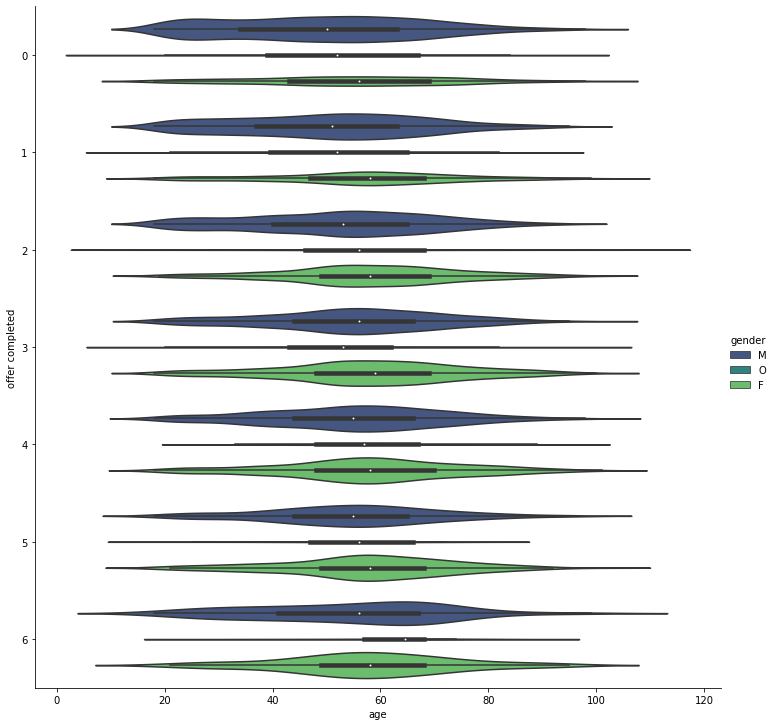

In [13]:
display(profile_trans_merged.gender.value_counts())

sns.catplot(data = profile_trans_merged, hue = 'gender', x = 'age', y = 'offer completed', orient = 'h', kind = 'violin', palette = 'viridis', height = 10, aspect = 1, scale = 'count')

## Comments: 
There are more men than women in the data set and only a few 'others'. 
Looking at the number of completed offers depending on the customer age and gender, some interesting findings can be made. In general, men complete fewer offers than women, which can be seen at the width difference of the respective violins. With higher numbers of completed offers, the share of women increases. Especially young men don't seem to complete many offers.

## 3) How do different age/gender groups interact with different offers?

,offer_id,offer_type,age,gender,money_gained,offer completed,offer received,offer viewed,income,completed/received,completed/viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(18.0, 33.0]",F,620.0,124.0,265.0,50.0,22728000.0,0.467925,2.480000
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(18.0, 33.0]",M,920.0,184.0,644.0,94.0,48122000.0,0.285714,1.957447
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(18.0, 33.0]",O,25.0,5.0,13.0,3.0,886000.0,0.384615,1.666667
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(33.0, 48.0]",F,1230.0,246.0,453.0,185.0,55237000.0,0.543046,1.329730
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(33.0, 48.0]",M,1685.0,337.0,854.0,279.0,88038000.0,0.394614,1.207885


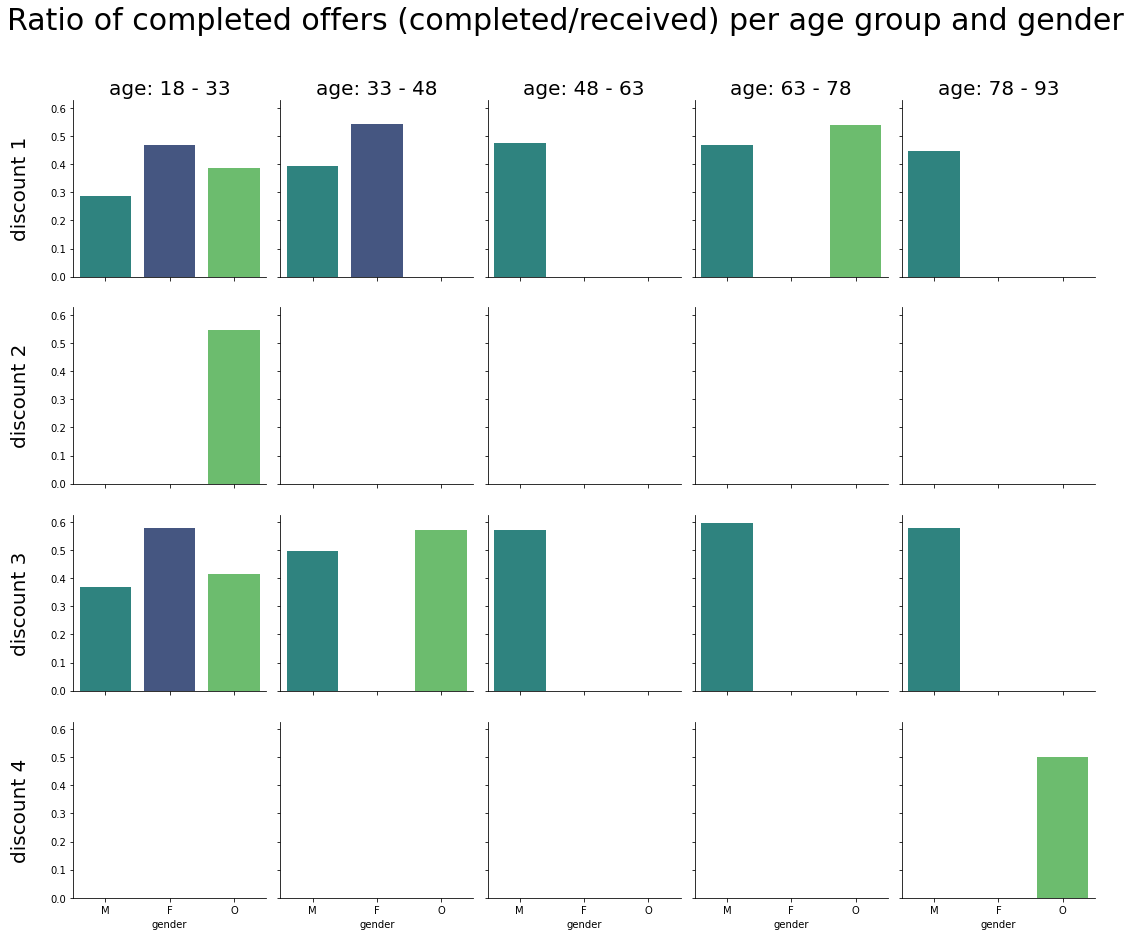

In [15]:
plot_completion_rate(t_p_p_merg, 'age', 15, 'discount', 'completed/received',  0.6)

## Comments:

From this bar plot the ratio of completed offers/received offers per age group and gender can be seen. If the completion ratio is higher than 60 %, the respective bar is not visualized for clarity reasons. The purpose of this plot is to highlight the offer/person group combinations that do not lead to a high completion rate. This allows to fastly detect the age and gender groups that do not complete the specific offer in a high number. In other words: discount 2 and discount 4 were completed by most of the customers, whereas discount 1 and discount 3 was not completed by so many customers. One could ask the following question: What can be learned from discount 2 and discount 4 to make discount 1 and discount 3 more effective? 

,offer_id,offer_type,age,gender,money_gained,offer completed,offer received,offer viewed,income,completed/received,completed/viewed,viewed/received
60,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"(18.0, 33.0]",F,1450.0,145.0,276.0,266.0,35840000.0,0.525362,0.545113,0.963768
61,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"(18.0, 33.0]",M,1520.0,152.0,679.0,638.0,74442000.0,0.223859,0.238245,0.939617
62,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"(18.0, 33.0]",O,30.0,3.0,5.0,5.0,666000.0,0.600000,0.600000,1.000000
63,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"(33.0, 48.0]",F,2860.0,286.0,456.0,443.0,73620000.0,0.627193,0.645598,0.971491
64,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"(33.0, 48.0]",M,3150.0,315.0,826.0,801.0,112731000.0,0.381356,0.393258,0.969734


()

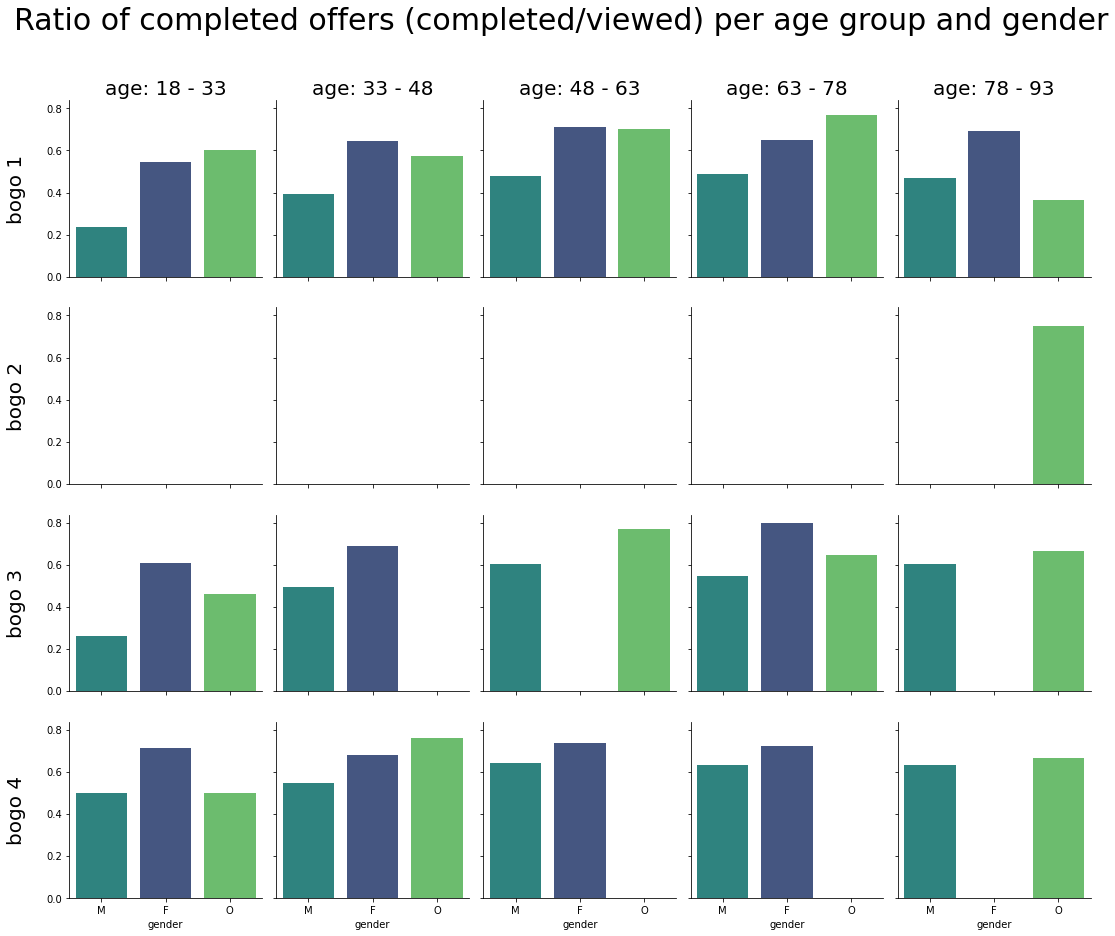

In [27]:
plot_completion_rate(t_p_p_merg, 'age', 15, 'bogo', 'completed/viewed',  0.8)

This bar graph now shows the completed/viewed ratio for different offers. If this ratio is higher than 1, there are more people that have completed this offer than have actually viewed it. This might happen if the offer itself is misplaced, sent at the wrong time (e.g. time of the day or weekday) or sent to the wrong customers. On the other hand, if the ratio is too close to 0 this would mean that people view the offer, but are not attracted by its benefits and then don't complete it. 
Therefore, the aim would be to have this completed/viewed ratio somewhere close to but below 1.

,offer_id,offer_type,age,gender,money_gained,offer completed,offer received,offer viewed,income,completed/received,completed/viewed,viewed/received
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(18.0, 33.0]",F,620.0,124.0,265.0,50.0,22728000.0,0.467925,2.480000,0.188679
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(18.0, 33.0]",M,920.0,184.0,644.0,94.0,48122000.0,0.285714,1.957447,0.145963
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(18.0, 33.0]",O,25.0,5.0,13.0,3.0,886000.0,0.384615,1.666667,0.230769
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(33.0, 48.0]",F,1230.0,246.0,453.0,185.0,55237000.0,0.543046,1.329730,0.408389
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"(33.0, 48.0]",M,1685.0,337.0,854.0,279.0,88038000.0,0.394614,1.207885,0.326698


()

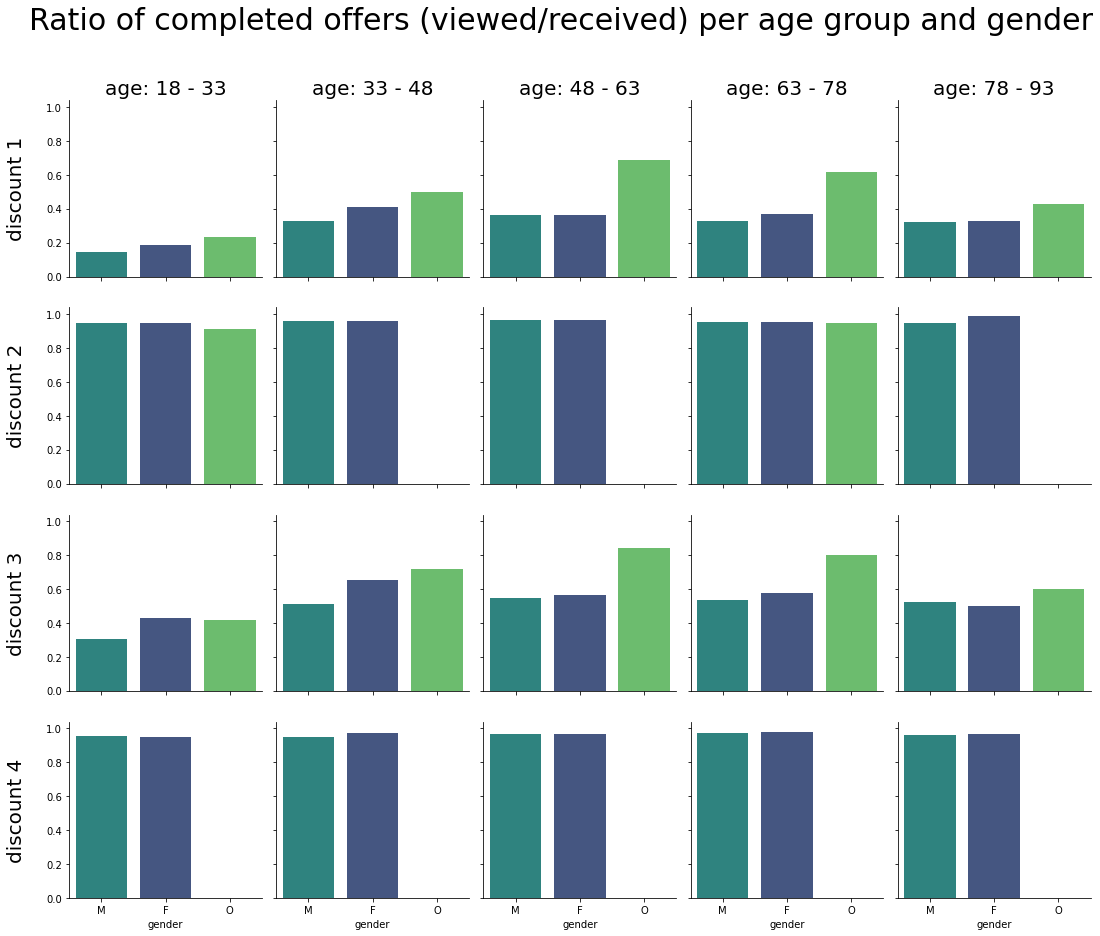

In [33]:
plot_completion_rate(t_p_p_merg, 'age', 15, 'discount', 'viewed/received',  1.0)

This graph shows the ratio of viewed/received, which is a measure for the "visibility" of the offer. If this value is close to 1, this might be a good indication that every receipient of the offer also viewed it. If the value is closer to zero, this offer was not viewed by the respective age/gender group. 
In the case of the discount offers, discount 1 and discount 3 were not viewed by many people, so it should be checked how (email, etc.) and when these offers were sent to the customers and how long they were active. 

## 4) Who received and completed which offer? - A detailed view

In [14]:
print('Age distribution:')
display(t_p_p_merg.age.agg(['mean', 'median']).round(1))
print('Income distribution:')
display(t_p_p_merg.income.agg(['mean', 'median']).round(0))

print('Distribution of age and income for persons who received/not received different offers:')
display(t_p_p_merg[['age', 'offer received', 'income']].groupby(['offer received']).agg(['mean', 'median', 'count']).round(1))

print('Distribution of age and income for persons who completed/not completed different offers:')
display(t_p_p_merg[['age', 'offer completed', 'income']].groupby(['offer completed']).agg(['mean', 'median', 'count']).round(1))

print('Distribution of age and income for the persons that received/not received the different offers:')
display(t_p_p_merg[['age', 'gender', 'offer_type', 'offer received', 'income', 'offer_id']].groupby(['offer_id', 'offer received', 'offer_type', 'gender']).agg(['mean', 'median', 'count', 'sum']).round(1))

print('Distribution of age and income for the persons that completed/not completed the different offers:')
display(t_p_p_merg[['age', 'gender', 'offer_type', 'offer completed', 'income', 'offer_id']].groupby(['offer_id', 'offer completed', 'offer_type', 'gender']).agg(['mean', 'median', 'count', 'sum']).round(1))

Age distribution:


mean      53.8
median    55.0
Name: age, dtype: float64

Income distribution:


mean      64337.0
median    62000.0
Name: income, dtype: float64

Distribution of age and income for persons who received/not received different offers:


age                  income                 
                mean median   count     mean   median   count
offer received                                               
0               53.7   55.0  206261  64003.4  62000.0  206261
1               54.4   55.0   66501  65371.6  64000.0   66501

Distribution of age and income for persons who completed/not completed different offers:


age                  income                 
                 mean median   count     mean   median   count
offer completed                                               
0                53.6   54.0  240318  63649.3  61000.0  240318
1                55.8   57.0   32444  69430.8  69000.0   32444

Distribution of age and income for the persons that received/not received the different offers:


age  \
                                                                      mean   
offer_id                         offer received offer_type    gender         
0b1e1539f2cc45b7b9fa7c272da2e1d7 0              discount      F       58.8   
                                                              M       54.7   
                                                              O       54.7   
                                 1              discount      F       57.6   
                                                              M       52.1   
                                                              O       51.8   
2298d6c36e964ae4a3e7e9706d1fb8c2 0              discount      F       57.2   
                                                              M       52.5   
                                                              O       56.0   
                                 1              discount      F       57.1   
                                                              M       52.3   
                                                              O       55.5   
2906b810c7d4411798c6938adc9daaa5 0              discount      F       57.8   
                                                              M       54.4   
                                                              O       57.2   
                                 1              discount      F       57.5   
                                                              M       51.8   
                                                              O       55.1   
3f207df678b143eea3cee63160fa8bed 0              informational F       58.0   
                                                              M       54.4   
                                                              O       57.5   
                                 1              informational F       57.4   
                                                              M       52.5   
                                                              O       56.3   
4d5c57ea9a6940dd891ad53e9dbe8da0 0              bogo          F       57.9   
                                                              M       52.9   
                                                              O       58.4   
                                 1              bogo          F       57.6   
                                                              M       51.8   
                                                              O       58.8   
5a8bc65990b245e5a138643cd4eb9837 0              informational F       56.7   
                                                              M       51.8   
                                                              O       54.2   
                                 1              informational F       57.4   
                                                              M       52.5   
                                                              O       54.5   
9b98b8c7a33c4b65b9aebfe6a799e6d9 0              bogo          F       57.6   
                                                              M       53.5   
                                                              O       56.9   
                                 1              bogo          F       57.4   
                                                              M       52.2   
                                                              O       56.2   
ae264e3637204a6fb9bb56bc8210ddfd 0              bogo          F       57.6   
                                                              M       52.4   
                                                              O       53.7   
                                 1              bogo          F       57.7   
                                                              M       51.7   
                                                              O       53.4   
f19421c1d4aa40978ebb69ca19b0e20d 0              bogo          F       57.4   
               

Distribution of age and income for the persons that completed/not completed the different offers:


age  \
                                                                       mean   
offer_id                         offer completed offer_type    gender         
0b1e1539f2cc45b7b9fa7c272da2e1d7 0               discount      F       57.9   
                                                               M       52.8   
                                                               O       53.0   
                                 1               discount      F       58.8   
                                                               M       54.5   
                                                               O       54.4   
2298d6c36e964ae4a3e7e9706d1fb8c2 0               discount      F       57.1   
                                                               M       52.3   
                                                               O       55.5   
                                 1               discount      F       57.2   
                                                               M       52.8   
                                                               O       56.6   
2906b810c7d4411798c6938adc9daaa5 0               discount      F       57.5   
                                                               M       52.7   
                                                               O       56.0   
                                 1               discount      F       58.0   
                                                               M       54.3   
                                                               O       57.0   
3f207df678b143eea3cee63160fa8bed 0               informational F       57.6   
                                                               M       53.1   
                                                               O       56.8   
4d5c57ea9a6940dd891ad53e9dbe8da0 0               bogo          F       57.6   
                                                               M       51.9   
                                                               O       58.7   
                                 1               bogo          F       58.3   
                                                               M       55.3   
                                                               O       58.1   
5a8bc65990b245e5a138643cd4eb9837 0               informational F       57.0   
                                                               M       52.2   
                                                               O       54.4   
9b98b8c7a33c4b65b9aebfe6a799e6d9 0               bogo          F       57.5   
                                                               M       52.7   
                                                               O       56.5   
                                 1               bogo          F       57.5   
                                                               M       53.2   
                                                               O       56.8   
ae264e3637204a6fb9bb56bc8210ddfd 0               bogo          F       57.4   
                                                               M       51.5   
                                                               O       53.3   
                                 1               bogo          F       58.4   
                                                               M       54.7   
                                                               O       54.4   
f19421c1d4aa40978ebb69ca19b0e20d 0               bogo          F       57.2   
                                                               M       52.5   
                                                               O       52.6   
                                 1               bogo          F       57.6   
                                                               M       54.0   
                                                               O       54.9   
fafdcd668e3743c1bb461111dcafc2a4 0         

## Comments: 
For the complete dataset the age has a mean of 53.8 years and a median age of 55 years. The average and median income is 64337 and 62000 dollars respectively. From the statistics it can be seen that the average person who receives an offer is 54.4 years old and earns 65371.6 dollars. The average person that completes an offer is 55.8 years old and earns 69430.8 dollars. 
From this analysis it can be deduced that older and more wealthy people tend to interact more with the different offers. This is also true for a deeper look at the different offers independently. The average person who receives and completes an offer is generally older and wealthier than the average customer in the whole dataset. 
